In [1]:
import altair as alt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import wordcloud as wc
import sqlite3
import datetime
# import stats
from sklearn.cluster import KMeans

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

%load_ext sql
# %config InlineBackend.figure_formats = ['svg']

# Load data

In [2]:
ldf = pd.read_csv('crime_data.csv', index_col='Report Number', parse_dates=['Occurred Date', 'Reported Date'])
ldf.head()

,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
Report Number,,,,,,,,,,
20080000465209,2008-12-13,2114.0,2008-12-13,2114.0,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
20100000202011,2064-06-15,0.0,2010-06-15,1031.0,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,WEST,Q,Q2,QUEEN ANNE
2012000023437,1973-01-01,0.0,2012-01-25,1048.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,NORTH,N,N2,NORTHGATE
20130000327785,1974-06-01,0.0,2013-09-09,1117.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
20160000289384,1975-01-01,0.0,2016-08-11,1054.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN


# Clean dataset

In [3]:
rdf = ldf.copy()
rdf = rdf.drop(['Occurred Time', 'Reported Time'], axis=1)
rdf = rdf.rename(columns = {
  'Occurred Date': 'Occurred',
  'Reported Date': 'Reported',
  'Crime Subcategory': 'Subcategory',
  'Primary Offense Description': 'Description',
})
rdf = rdf[(~rdf['Occurred'].isna()) & (~rdf['Subcategory'].isna())]
rdf = rdf[(rdf['Occurred'] >= '2008') & (rdf['Occurred'] < datetime.datetime.now())]
rdf.head()

,Occurred,Reported,Subcategory,Description,Precinct,Sector,Beat,Neighborhood
Report Number,,,,,,,,
20080000465209,2008-12-13,2008-12-13,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
200800001981,2008-01-01,2008-01-02,CAR PROWL,THEFT-CARPROWL,SOUTHWEST,F,F3,SOUTH PARK
200800001265,2008-01-01,2008-01-01,NARCOTIC,NARC-SELL-METH,SOUTHWEST,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS
200800001903,2008-01-01,2008-01-02,CAR PROWL,THEFT-AUTOACC,SOUTHWEST,F,F3,SOUTH PARK
200800001226,2008-01-01,2008-01-01,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B2,FREMONT


In [20]:
df = rdf.copy()

# Take a look at each column

In [5]:
df.head(10)

,Occurred,Reported,Subcategory,Description,Precinct,Sector,Beat,Neighborhood
Report Number,,,,,,,,
20080000465209,2008-12-13,2008-12-13,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
200800001981,2008-01-01,2008-01-02,CAR PROWL,THEFT-CARPROWL,SOUTHWEST,F,F3,SOUTH PARK
200800001265,2008-01-01,2008-01-01,NARCOTIC,NARC-SELL-METH,SOUTHWEST,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS
200800001903,2008-01-01,2008-01-02,CAR PROWL,THEFT-AUTOACC,SOUTHWEST,F,F3,SOUTH PARK
200800001226,2008-01-01,2008-01-01,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B2,FREMONT
200800001201,2008-01-01,2008-01-01,DUI,DUI-LIQUOR,EAST,E,E2,CAPITOL HILL
200800001523,2008-01-01,2008-01-02,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,WEST,Q,Q3,QUEEN ANNE
200800001172,2008-01-01,2008-01-01,BURGLARY-COMMERCIAL,BURGLARY-NOFORCE-NONRES,WEST,Q,Q3,QUEEN ANNE
200900001718,2008-01-01,2009-01-02,CAR PROWL,THEFT-AUTOACC,EAST,C,C3,CENTRAL AREA/SQUIRE PARK


In [7]:
df[['Subcategory', 'Description', 'Sector', 'Precinct', 'Neighborhood']].nunique()

Subcategory      30
Description     142
Sector           23
Precinct          6
Neighborhood     59
dtype: int64

In [8]:
subcategories = list(df['Subcategory'].unique())
subcategories

['DUI',
 'CAR PROWL',
 'NARCOTIC',
 'ROBBERY-STREET',
 'BURGLARY-RESIDENTIAL',
 'BURGLARY-COMMERCIAL',
 'MOTOR VEHICLE THEFT',
 'THEFT-SHOPLIFT',
 'SEX OFFENSE-OTHER',
 'THEFT-BUILDING',
 'THEFT-ALL OTHER',
 'RAPE',
 'AGGRAVATED ASSAULT',
 'TRESPASS',
 'LIQUOR LAW VIOLATION',
 'FAMILY OFFENSE-NONVIOLENT',
 'ROBBERY-RESIDENTIAL',
 'AGGRAVATED ASSAULT-DV',
 'WEAPON',
 'PROSTITUTION',
 'THEFT-BICYCLE',
 'HOMICIDE',
 'LOITERING',
 'ARSON',
 'ROBBERY-COMMERCIAL',
 'DISORDERLY CONDUCT',
 'PORNOGRAPHY',
 'GAMBLE',
 'BURGLARY-RESIDENTIAL-SECURE PARKING',
 'BURGLARY-COMMERCIAL-SECURE PARKING']

In [9]:
del subcategories[23]

In [10]:
subcategories

['DUI',
 'CAR PROWL',
 'NARCOTIC',
 'ROBBERY-STREET',
 'BURGLARY-RESIDENTIAL',
 'BURGLARY-COMMERCIAL',
 'MOTOR VEHICLE THEFT',
 'THEFT-SHOPLIFT',
 'SEX OFFENSE-OTHER',
 'THEFT-BUILDING',
 'THEFT-ALL OTHER',
 'RAPE',
 'AGGRAVATED ASSAULT',
 'TRESPASS',
 'LIQUOR LAW VIOLATION',
 'FAMILY OFFENSE-NONVIOLENT',
 'ROBBERY-RESIDENTIAL',
 'AGGRAVATED ASSAULT-DV',
 'WEAPON',
 'PROSTITUTION',
 'THEFT-BICYCLE',
 'HOMICIDE',
 'LOITERING',
 'ROBBERY-COMMERCIAL',
 'DISORDERLY CONDUCT',
 'PORNOGRAPHY',
 'GAMBLE',
 'BURGLARY-RESIDENTIAL-SECURE PARKING',
 'BURGLARY-COMMERCIAL-SECURE PARKING']

In [11]:
sorted(subcategories, key = str.lower)

['AGGRAVATED ASSAULT',
 'AGGRAVATED ASSAULT-DV',
 'BURGLARY-COMMERCIAL',
 'BURGLARY-COMMERCIAL-SECURE PARKING',
 'BURGLARY-RESIDENTIAL',
 'BURGLARY-RESIDENTIAL-SECURE PARKING',
 'CAR PROWL',
 'DISORDERLY CONDUCT',
 'DUI',
 'FAMILY OFFENSE-NONVIOLENT',
 'GAMBLE',
 'HOMICIDE',
 'LIQUOR LAW VIOLATION',
 'LOITERING',
 'MOTOR VEHICLE THEFT',
 'NARCOTIC',
 'PORNOGRAPHY',
 'PROSTITUTION',
 'RAPE',
 'ROBBERY-COMMERCIAL',
 'ROBBERY-RESIDENTIAL',
 'ROBBERY-STREET',
 'SEX OFFENSE-OTHER',
 'THEFT-ALL OTHER',
 'THEFT-BICYCLE',
 'THEFT-BUILDING',
 'THEFT-SHOPLIFT',
 'TRESPASS',
 'WEAPON']

Note: To reduce the number of categories, I decided to group some of them together below

In [12]:
subcategory_map = {
  'AGGRAVATED ASSAULT': 'ASSAULT',
  'AGGRAVATED ASSAULT-DV': 'ASSAULT',
  'BURGLARY-COMMERCIAL': 'BURGLARY',
  'BURGLARY-COMMERCIAL-SECURE PARKING': 'BURGLARY',
  'BURGLARY-RESIDENTIAL': 'BURGLARY',
  'BURGLARY-RESIDENTIAL-SECURE PARKING': 'BURGLARY',
  'DISORDERLY CONDUCT': 'DISORDERLY CONDUCT',
  'LOITERING': 'DISORDERLY CONDUCT',
  'TRESPASS': 'DISORDERLY CONDUCT',
  'DUI': 'SUBSTANCE',
  'LIQUOR LAW VIOLATION': 'SUBSTANCE',
  'NARCOTIC': 'SUBSTANCE',
  'PORNOGRAPHY': 'SEX OFFENSE',
  'PROSTITUTION': 'SEX OFFENSE',
  'SEX OFFENSE-OTHER': 'SEX OFFENSE',
  'ROBBERY-COMMERCIAL': 'ROBBERY',
  'ROBBERY-RESIDENTIAL': 'ROBBERY',
  'ROBBERY-STREET': 'ROBBERY',
  'THEFT-ALL OTHER': 'THEFT',
  'THEFT-BICYCLE': 'THEFT',
  'THEFT-BUILDING': 'THEFT',
  'THEFT-SHOPLIFT': 'THEFT',
  'CAR PROWL': 'THEFT'
  
}


In [22]:
df['Category'] = df['Subcategory'].apply(lambda subcategory: subcategory_map.get(subcategory, subcategory))


In [26]:
df = df.groupby([pd.Grouper(key='Occurred', freq='MS'), 'Neighborhood', 'Category']).size().to_frame('Incidents').reset_index()

In [27]:
df.head(30)

,Occurred,Neighborhood,Category,Incidents
0,2008-01-01,ALASKA JUNCTION,ASSAULT,2
1,2008-01-01,ALASKA JUNCTION,BURGLARY,10
2,2008-01-01,ALASKA JUNCTION,DISORDERLY CONDUCT,3
3,2008-01-01,ALASKA JUNCTION,MOTOR VEHICLE THEFT,4
4,2008-01-01,ALASKA JUNCTION,ROBBERY,1
5,2008-01-01,ALASKA JUNCTION,SEX OFFENSE,2
6,2008-01-01,ALASKA JUNCTION,SUBSTANCE,5
7,2008-01-01,ALASKA JUNCTION,THEFT,9
8,2008-01-01,ALKI,BURGLARY,3
9,2008-01-01,ALKI,RAPE,1


# How has the number of incidents fluctuated over the years by type of crime (and by Neighborhood)?

In [54]:
categories = list(df.Category.unique())
categories

['BURGLARY',
 'DISORDERLY CONDUCT',
 'MOTOR VEHICLE THEFT',
 'ROBBERY',
 'SEX OFFENSE',
 'SUBSTANCE',
 'THEFT',
 'WEAPON',
 'ASSAULT',
 'RAPE',
 'HOMICIDE',
 'FAMILY OFFENSE-NONVIOLENT',
 'ARSON']

In [34]:
neighborhoods = list(df.Neighborhood.unique())
neighborhoods

['ALASKA JUNCTION',
 'ALKI',
 'BALLARD NORTH',
 'BALLARD SOUTH',
 'BELLTOWN',
 'BITTERLAKE',
 'BRIGHTON/DUNLAP',
 'CAPITOL HILL',
 'CENTRAL AREA/SQUIRE PARK',
 'CHINATOWN/INTERNATIONAL DISTRICT',
 'CLAREMONT/RAINIER VISTA',
 'COLUMBIA CITY',
 'COMMERCIAL DUWAMISH',
 'COMMERCIAL HARBOR ISLAND',
 'DOWNTOWN COMMERCIAL',
 'EASTLAKE - EAST',
 'EASTLAKE - WEST',
 'FAUNTLEROY SW',
 'FIRST HILL',
 'FREMONT',
 'GENESEE',
 'GEORGETOWN',
 'GREENWOOD',
 'HIGH POINT',
 'HIGHLAND PARK',
 'HILLMAN CITY',
 'JUDKINS PARK/NORTH BEACON HILL',
 'LAKECITY',
 'LAKEWOOD/SEWARD PARK',
 'MADISON PARK',
 'MADRONA/LESCHI',
 'MAGNOLIA',
 'MID BEACON HILL',
 'MILLER PARK',
 'MONTLAKE/PORTAGE BAY',
 'MORGAN',
 'MOUNT BAKER',
 'NEW HOLLY',
 'NORTH ADMIRAL',
 'NORTH BEACON HILL',
 'NORTH DELRIDGE',
 'NORTHGATE',
 'PHINNEY RIDGE',
 'PIGEON POINT',
 'PIONEER SQUARE',
 'QUEEN ANNE',
 'RAINIER BEACH',
 'RAINIER VIEW',
 'ROOSEVELT/RAVENNA',
 'ROXHILL/WESTWOOD/ARBOR HEIGHTS',
 'SANDPOINT',
 'SLU/CASCADE',
 'SODO',
 'SOUTH 

Note: To match Abbie's presentation on Fifi data, I grouped some neighborhoods together. 

In [35]:
neighborhood_map = {
  'FREMONT': 'Fmt/Wfd/GW',
  'WALLINGFORD': 'Fmt/Wfd/GW',
  'GREENWOOD': 'Fmt/Wfd/GW',
  'MID BEACON HILL': 'BH/GT',
  'GEORGETOWN': 'BH/GT',
  'BALLARD NORTH': 'Ballard',
  'BALLARD SOUTH': 'Ballard',
  'CAPITOL HILL': 'CapitolH/Eastlk',
  'EASTLAKE - EAST': 'CapitolH/Eastlk',
  'EASTLAKE - WEST': 'CapitolH/Eastlk',
  'BELLTOWN': 'Blltwn/Dwntwn/PionrSq',
  'DOWNTOWN COMMERCIAL': 'Blltwn/Dwntwn/PionrSq',
  'PIONEER SQUARE': 'Blltwn/Dwntwn/PionrSq'  
}


In [36]:
df['Neighborhood'] = df['Neighborhood'].apply(lambda neighborhood: neighborhood_map.get(neighborhood, neighborhood))

In [44]:
df = df[df.Category != 'GAMBLE']
df.head(30)

,Occurred,Neighborhood,Category,Incidents
12,2008-01-01,Ballard,BURGLARY,17
13,2008-01-01,Ballard,DISORDERLY CONDUCT,1
14,2008-01-01,Ballard,MOTOR VEHICLE THEFT,9
15,2008-01-01,Ballard,ROBBERY,5
16,2008-01-01,Ballard,SEX OFFENSE,1
17,2008-01-01,Ballard,SUBSTANCE,1
18,2008-01-01,Ballard,THEFT,38
19,2008-01-01,Ballard,BURGLARY,11
20,2008-01-01,Ballard,DISORDERLY CONDUCT,4
21,2008-01-01,Ballard,MOTOR VEHICLE THEFT,18


Note: There are too many neighborhoods, so I picked the ones that Abbie highlighted in her talk, and included the downtown area just out of my own curiosity.

In [48]:
neighborhoods = ['Fmt/Wfd/GW', 'QUEEN ANNE', 'BH/GT', 'Ballard', 'MAGNOLIA', 'CapitolH/Eastlk', 'Blltwn/Dwntwn/PionrSq']
df = df[df.Neighborhood.isin(neighborhoods)]

In [46]:
df.head(10)

,Occurred,Neighborhood,Category,Incidents
12,2008-01-01,Ballard,BURGLARY,17
13,2008-01-01,Ballard,DISORDERLY CONDUCT,1
14,2008-01-01,Ballard,MOTOR VEHICLE THEFT,9
15,2008-01-01,Ballard,ROBBERY,5
16,2008-01-01,Ballard,SEX OFFENSE,1
17,2008-01-01,Ballard,SUBSTANCE,1
18,2008-01-01,Ballard,THEFT,38
19,2008-01-01,Ballard,BURGLARY,11
20,2008-01-01,Ballard,DISORDERLY CONDUCT,4
21,2008-01-01,Ballard,MOTOR VEHICLE THEFT,18


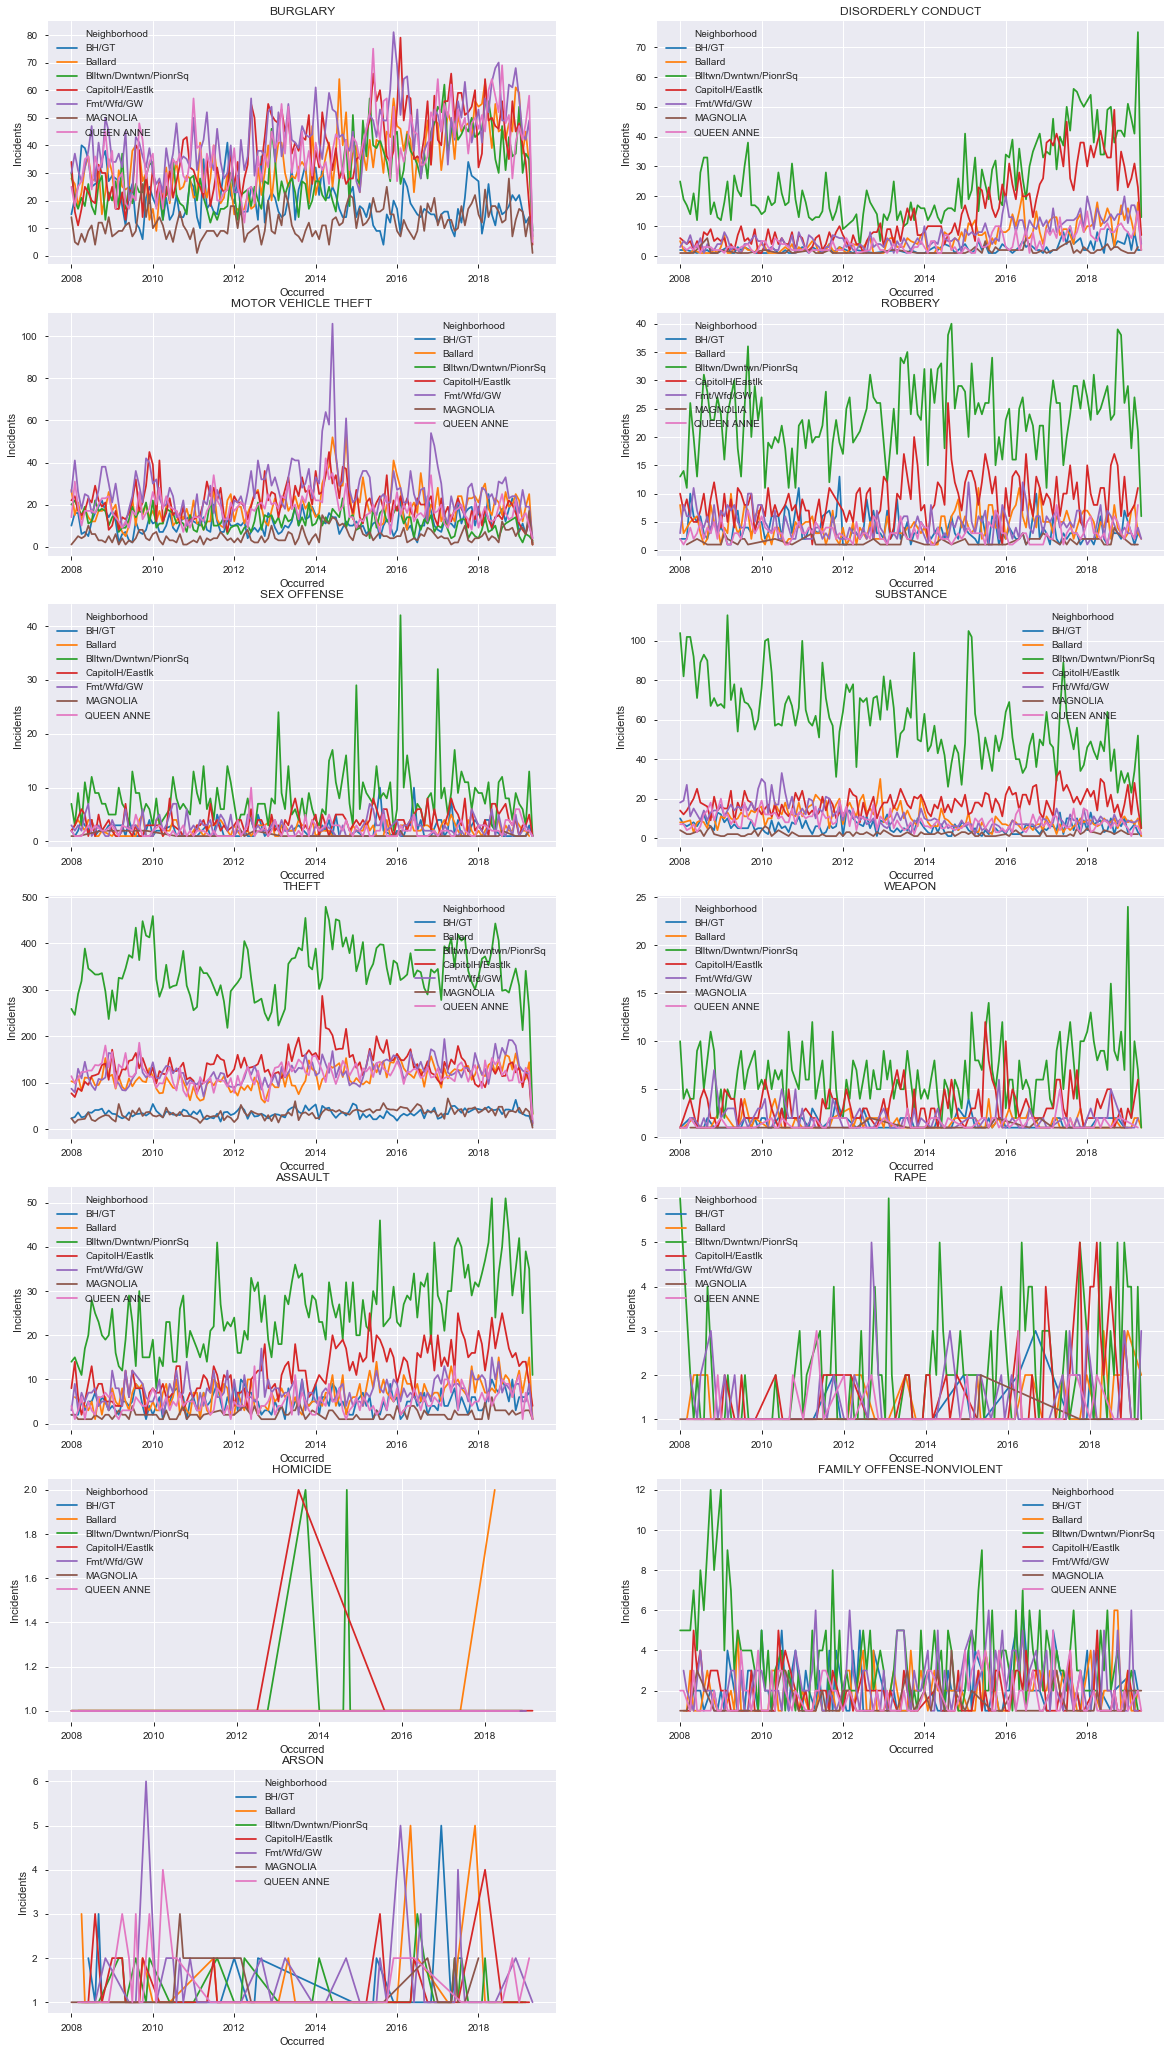

In [55]:
fig = plt.figure(figsize=(20, 160))
for i, crime_type in enumerate(categories):
  crime_type_data = df[df.Category == crime_type]
  crime_type_data = crime_type_data.groupby(['Neighborhood', 'Occurred'])['Incidents'].sum().reset_index()

  fig.add_subplot(30, 2, i + 1)
  sns.lineplot(x="Occurred", y="Incidents", hue="Neighborhood", data=crime_type_data)

  ax = plt.gca()
  ax.set_title(crime_type)

Note: Not surprisingly, the downtown/Belltown/Pinoneer Square area has had more incidents than other neighborhoods in general.

# Combining all years, are there crime types that are more common within each neighborhood?

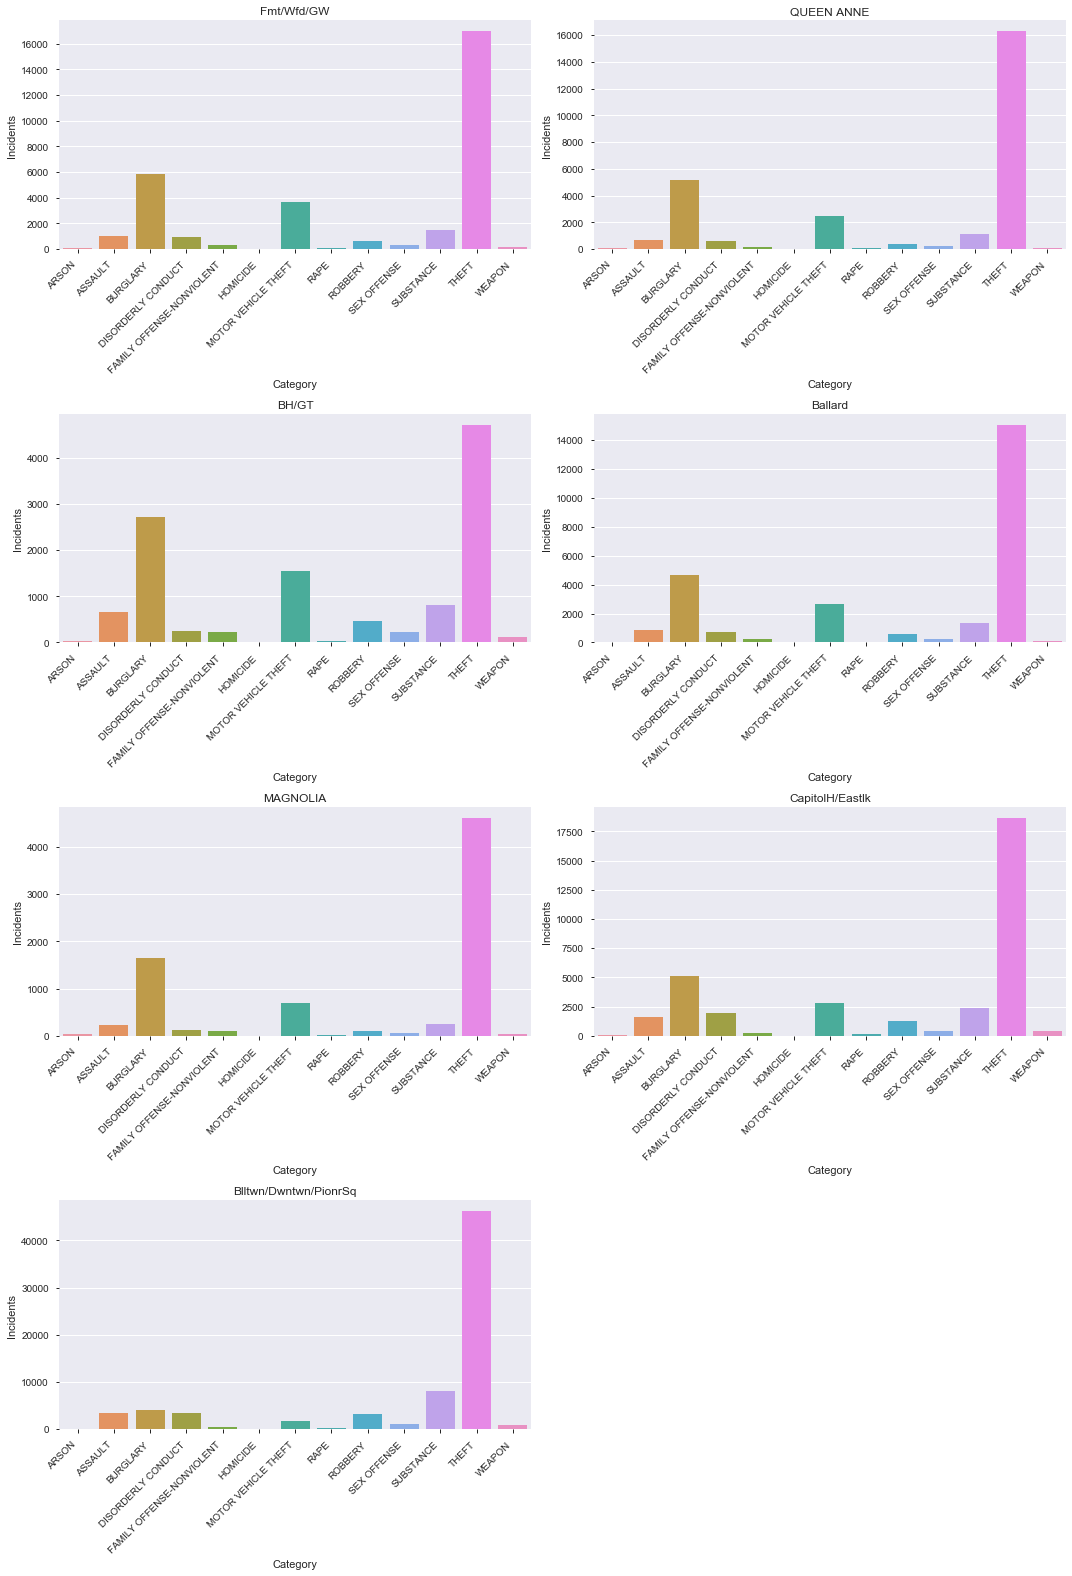

In [66]:
fig = plt.figure(figsize=(15, 22))
for i, neighborhood in enumerate(neighborhoods):
  neighborhood_data = df[df.Neighborhood == neighborhood]
  neighborhood_data = neighborhood_data.groupby(['Neighborhood', 'Category'])['Incidents'].sum().reset_index()

  fig.add_subplot(4, 2, i + 1)
  chart = sns.barplot(data= neighborhood_data, x= 'Category', y= 'Incidents')
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

  ax = plt.gca()
  ax.set_title(neighborhood)
plt.tight_layout()

Note: In all neighborhoods, theft is the most common type of crime.

# Combining all years, were there more incidents in some neighborhoods than others (by crime type)? 

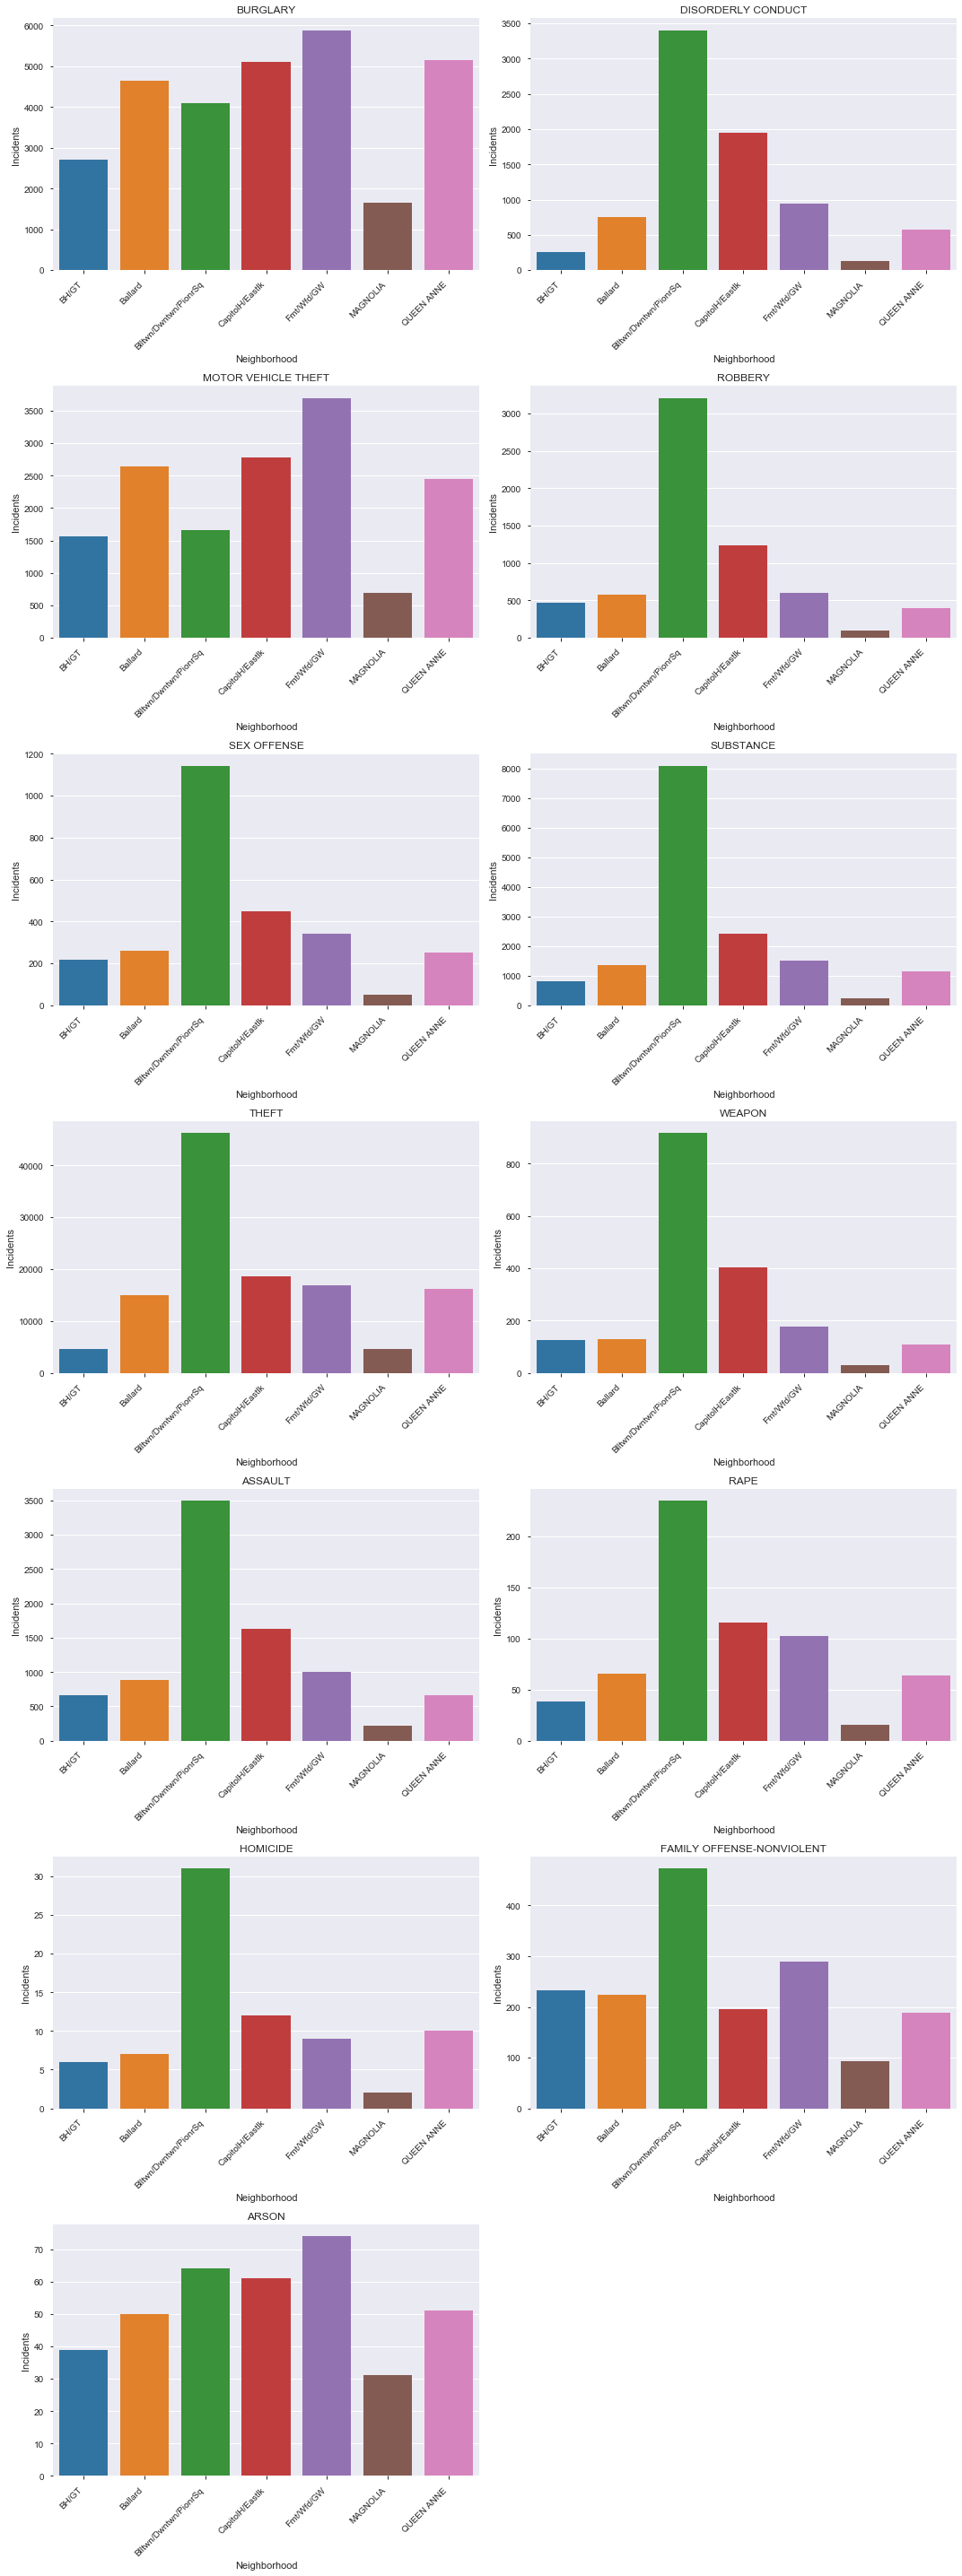

In [65]:
fig = plt.figure(figsize=(15, 40))
for i, crime_type in enumerate(categories):
  crime_type_data = df[df.Category == crime_type]
  crime_type_data = crime_type_data.groupby(['Neighborhood', 'Category'])['Incidents'].sum().reset_index()

  fig.add_subplot(7, 2, i + 1)
  chart = sns.barplot(data=crime_type_data, x='Neighborhood', y='Incidents')
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
  
  ax = plt.gca()
  ax.set_title(crime_type)

plt.tight_layout()

Note: Again, the downtown area has had more incidents than other neighborhoods, followed by the Fremont/Wallingoford/Greenwood area and Capitol Hill/East Lake area.